# Проект 2

### Выполнили:
Бабин Савелий \\
Михайлов Михаил \\
Кляхандлер Сергей

In [1]:
# импортируем необходимые библиотеки
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib
from pylab import rcParams
import itertools
from statsmodels.tsa.stattools import kpss
import seaborn as sns
from statsmodels.tsa.api import acf, pacf, graphics
import statsmodels.api as sm   

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from itertools import product
from tqdm import tqdm_notebook
warnings.filterwarnings("ignore")    
%matplotlib inline
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()

In [2]:
# считываем датасет
df = pd.read_csv('project_2_data.csv')

In [3]:
# посмотрим сколько пропущенных значений
df.isnull().sum()

date      0
target    0
dtype: int64

In [4]:
df.describe()

,target
count,220.000000
mean,514.590909
std,313.564404
min,1.000000
25%,309.000000
50%,378.500000
75%,751.250000
max,1571.000000


In [5]:
df.date = pd.to_datetime(df.date, infer_datetime_format=True)
df = df.set_index('date')

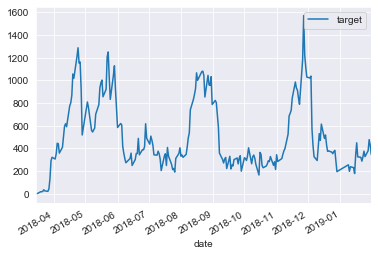

In [6]:
df.plot()

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

К сожалению, мы не можем делать прогнозы на далекое будущее - чтобы получить значение для следующего шага, нам нужно, чтобы предыдущие значения действительно наблюдались. Но с помощью скользящего среднего можно сгладить исходный временной ряд для выявления тенденций. В случае очень зашумленных данных, которые часто встречаются в финансах, эта процедура может помочь обнаружить общие закономерности.

In [8]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96):

    """
    Функция вычисляющая и строящая скользящее среднее
        series - временные данные
        window - скользящее окно 
        plot_intervals - доверительные интервалы
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Строим доверительные интервалы для сглаженных значений
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

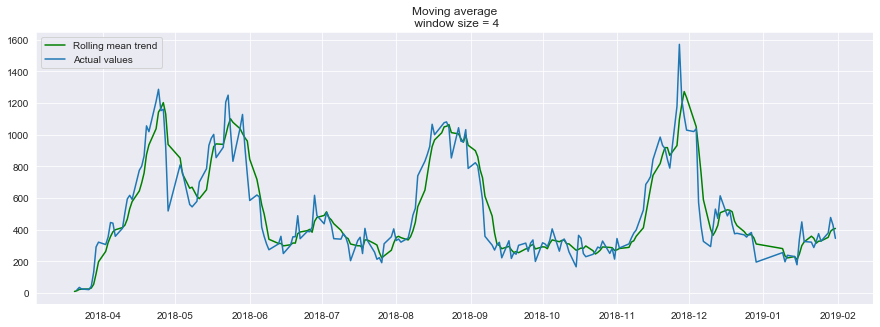

In [9]:
plotMovingAverage(df.target, 4) 

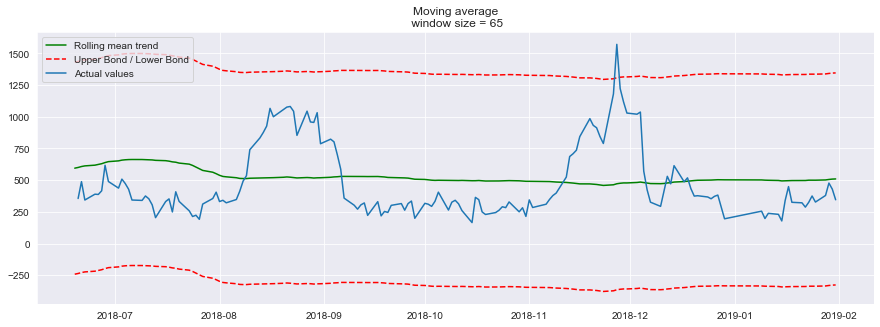

In [10]:
# сгладим за 65 дней
plotMovingAverage(df.target, 65, plot_intervals=True)

In [27]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Функция отрисовывающая ряд, его ACF b PACF и считающая тест кпсс
        
        y - временной ряд
        lags - сколько лагов включать в ACF, PACF расчеты
    """
    _, p_value, _, _ = kpss(y)

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots\n KPSS test: p-value =  {0:.5f}\n'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

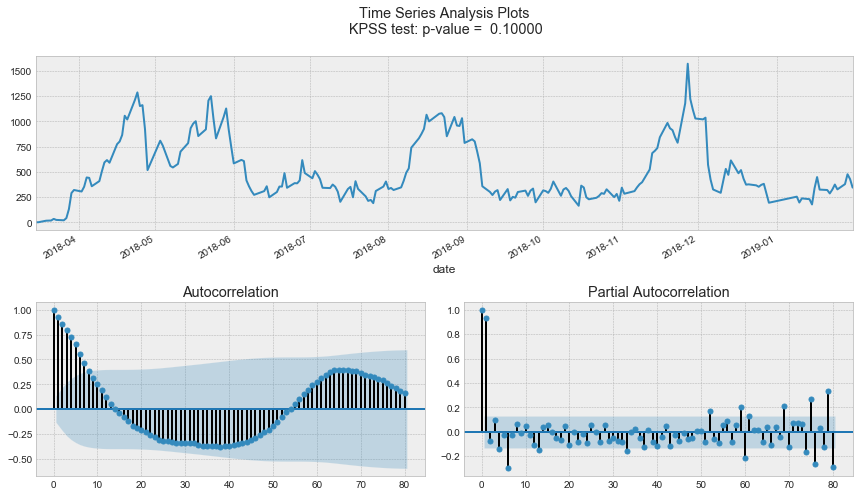

In [28]:
tsplot(df.target, lags=80)

Удивительно, но начальный ряд стационарен; тест KPSS принимает нулевую гипотезу. Собственно, мы можем видеть это на самом графике - у нас нет видимого тренда, поэтому среднее значение постоянно, а дисперсия в значительной степени стабильна. Остается только сезонность, с которой мы должны разобраться до моделирования. Для этого возьмем «сезонную разницу», что означает простое вычитание ряда из самого себя с лагом, равным сезонному периоду.

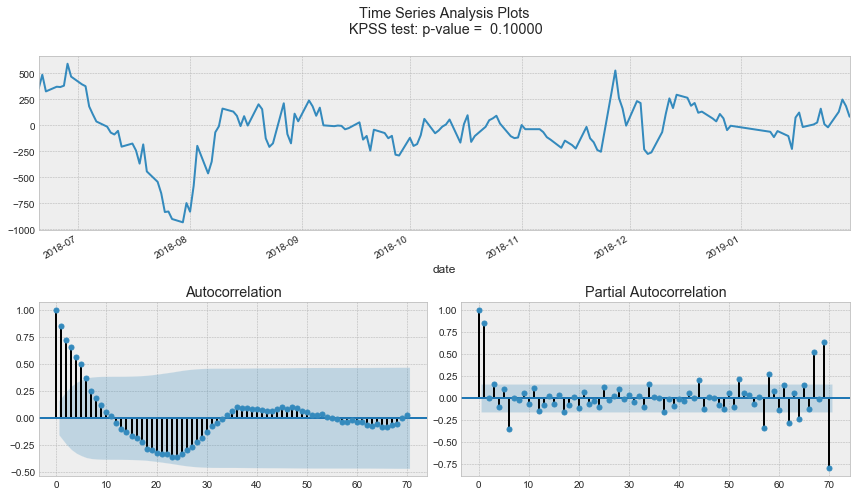

In [31]:
df_diff = df.target - df.target.shift(65)
tsplot(df_diff[65:], lags=70)

Сейчас ситуация намного лучше, когда исчезла видимая сезонность. Однако автокорреляционная функция по-прежнему имеет слишком много значительных лагов. Чтобы удалить их, мы возьмем первые отличия, вычтя ряд из себя с лагом 1.

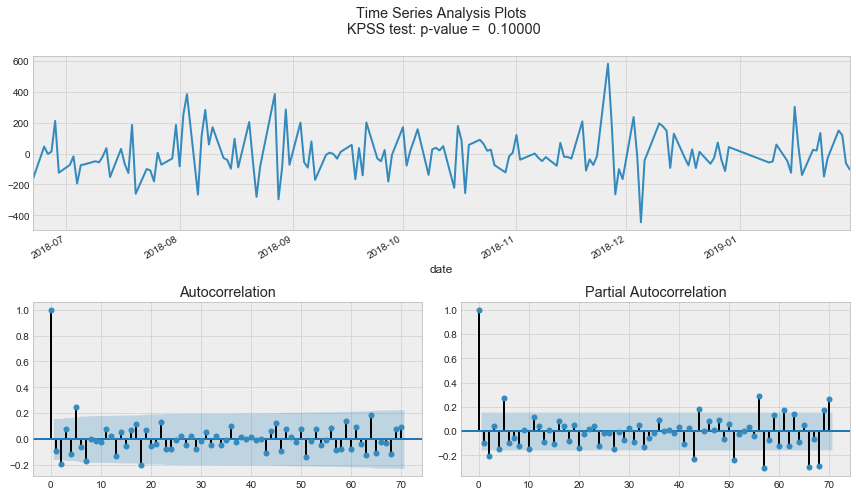

In [32]:
df_diff = df_diff - df_diff.shift(1)
tsplot(df_diff[65+2:], lags=70)

Идеально! Наш ряд сейчас колеблется около нуля. Тест KPSS показывает, что он стационарный, и количество значимых пиков в ACF уменьшилось. Наконец-то мы можем приступить к моделированию!

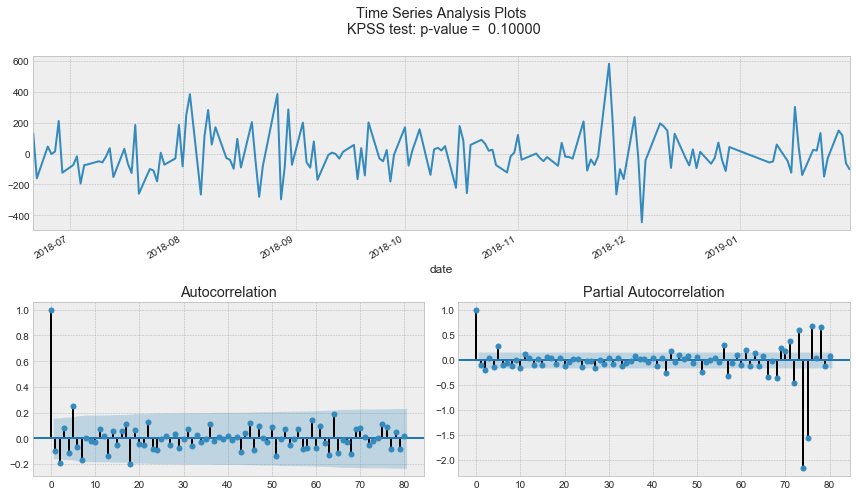

In [34]:
tsplot(df_diff[65+1:], lags=80)


p - Скорее всего, 5, поскольку это последний значительный lag от PACF, после которого большинство других не являются значительными

d - равно 1, потому что мы один раз вычитали ряд

q - должно быть где-то около 5, как видно на ACF

P - может быть 1

D - снова равно 1, потому что мы провели одну сезонную дифференциацию

Q - скорее всего 0

In [42]:
# установим начальные параметры и некоторые границы для них
ps = range(2, 6)
d = 1  
qs = range(2, 6)
Ps = range(0, 2)
D = 1 
Qs = range(0, 2)
s = 65 # длина сезона

# список с комбинациями параметров
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [43]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Функция возвращающая таблицу с параметрами и соответствующим AIC
        
        parameters_list - список с (p, q, P, Q) кортежами
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # нам нужно try-except, потому что, что в некоторых комбинациях модель может не сходиться
        try:
            model=sm.tsa.statespace.SARIMAX(df.target, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # сохраняем лучшую модель, AIC и параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем в возрастающем порядке, чем меньше AIC тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [44]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [45]:
result_table.head()

,parameters,aic
0,"(3, 3, 1, 0)",1944.484285
1,"(4, 4, 1, 0)",1944.505106
2,"(4, 5, 1, 0)",1944.717021
3,"(2, 5, 1, 0)",1945.132650
4,"(3, 4, 1, 0)",1945.433761


In [46]:
# зафиксируем лучшие параметры
p, q, P, Q = result_table.parameters[np.argmin(result_table.aic)]

best_model=sm.tsa.statespace.SARIMAX(df.target, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             target   No. Observations:                  220
Model:             SARIMAX(3, 1, 3)x(1, 1, 0, 65)   Log Likelihood                -964.242
Date:                            Tue, 23 Feb 2021   AIC                           1944.484
Time:                                    13:08:10   BIC                           1968.780
Sample:                                         0   HQIC                          1954.353
                                            - 220                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1272      0.174      0.729      0.466      -0.215       0.469
ar.L2         -0.2797      0.133   

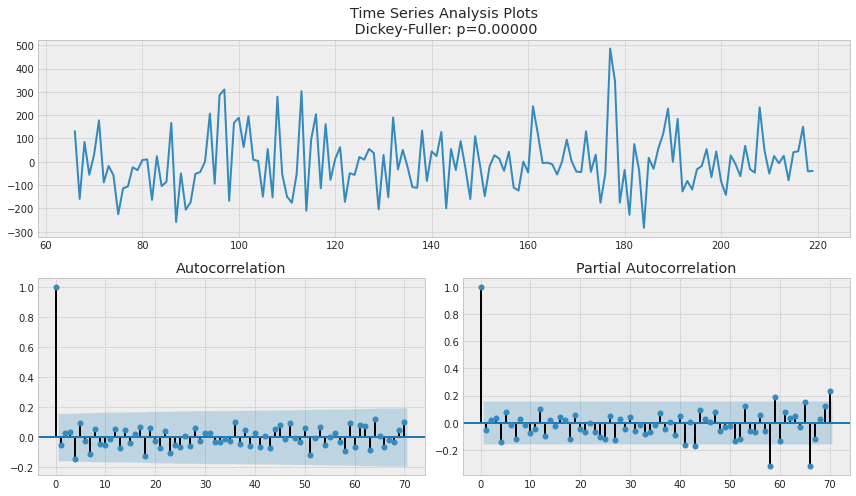

In [48]:
#
tsplot(best_model.resid[65+1:], lags=70)

Понятно, что невязки стационарны и явных автокорреляций нет. Сделаем прогнозы, используя нашу модель.

In [49]:
def plotSARIMA(series, model, n_steps=30):
    """
        Отрисовывает смоделированные и предсказанные значения ряда
        
        series - dataset с временным рядом
        model - SARIMA модель
        n_steps - число шагов, которые необходимо спрогнозировать
        
    """
    data = series.copy()
    data.columns = ["index",'target']
    data['arima_model'] = model.fittedvalues
    # делаем сдвиг на s + d шагов, потому что эти значения не наблюдались моделью
    # из-за дифференциации
    data['arima_model'][:s+d] = np.NaN
    
    # делаем предсказание на n_steps вперед
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, сдвинутую на s+d шагов от начала
    error = mean_absolute_percentage_error(data['target'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.target, label="actual")
    plt.savefig('result.png')
    plt.legend()
    plt.grid(True);

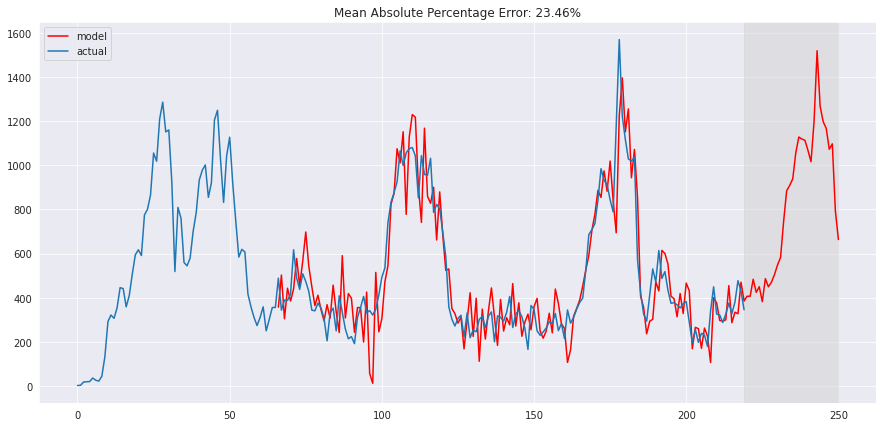

In [51]:
# финал

plotSARIMA(df, best_model, 30)

Итог: Для прогноза верменного ряда была испозована **SARIMA** модель со следующими параметрами:

p = 3

d = 1  

q = 3

P = 1

D = 1  

Q = 0

s = 65 